# Риск остеопороза у женщин

Для 500 участниц исследования Global Longitudinal Study of Osteoporosis in Women (Center for Outcomes Research, the University of Massachusetts/Worcester) измерены следующие показатели:

* возраст, лет (не меньше 55);
* вес, кг;
* рост, см;
* ИМТ, кг/см2;
* бинарные признаки: курение, индикатор наступления менопаузы до 45 лет, индикатор необходимости помощи при подъёме из сидячего положения, перелом шейки бедра в прошлом (был/не было), перелом шейки бедра у матери (был/не было);
* самостоятельная субъективная оценка вероятности перелома (меньше/такая же/больше, чем у сверстниц).


Известно, у кого из участниц в первый год исследования произошёл перелом шейки бедра. Необходимо построить модель вероятности перелома с учётом имеющихся признаков.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, chi2
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('GLOW500.txt', sep='\t')
df.head()

,PRIORFRAC,AGE,WEIGHT,HEIGHT,BMI,PREMENO,MOMFRAC,ARMASSIST,SMOKE,RATERISK,FRACTURE
0,no,62,70.3,158,28.16055,no,no,no,no,same,no
1,no,65,87.1,160,34.02344,no,no,no,no,same,no
2,yes,88,50.8,157,20.60936,no,yes,yes,no,less,no
3,no,82,62.1,160,24.25781,no,no,no,no,less,no
4,no,61,68.0,152,29.43213,no,no,no,no,same,no


In [3]:
df['FRACTURE'].value_counts()

no     375
yes    125
Name: FRACTURE, dtype: int64

## Разделимость по вещественным признакам

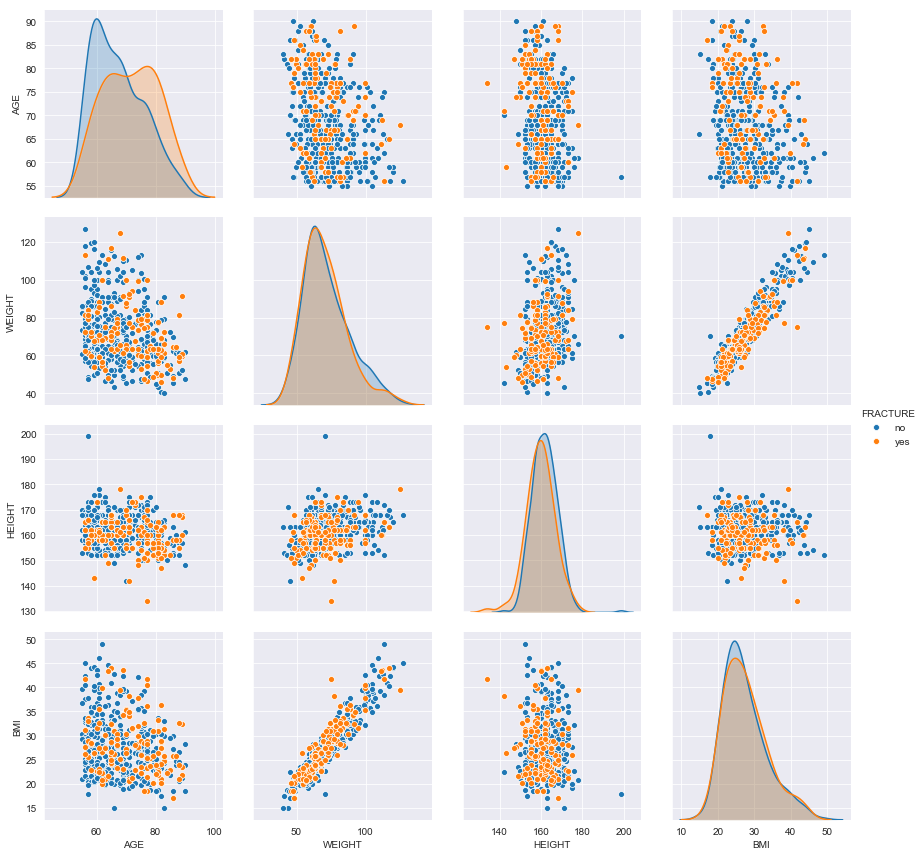

In [4]:
sns.pairplot(df, hue='FRACTURE', height=3.0) 

Разделимости по непрерывным признакам нет. Видно, что признак `AGE` является хорошим предиктором целевого значения

## Разделимость по категориальным признакам

In [5]:
df.dtypes

PRIORFRAC     object
AGE            int64
WEIGHT       float64
HEIGHT         int64
BMI          float64
PREMENO       object
MOMFRAC       object
ARMASSIST     object
SMOKE         object
RATERISK      object
FRACTURE      object
dtype: object

In [6]:
def compute_cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix, correction=False)[0]
    n = conf_matrix.sum().sum()
    k1, k2 = conf_matrix.shape
    return np.sqrt(chi2 / (n * (min(k1, k2) - 1)))

In [7]:
for col_name in ['PRIORFRAC', 'PREMENO', 'MOMFRAC', 'MOMFRAC', 'ARMASSIST', 'RATERISK', 'FRACTURE']:
    conf_matrix = pd.crosstab(df[col_name], df['FRACTURE'])
    cramers_v = compute_cramers_v(conf_matrix)
    print('{} has Cramer\s-V = {:.2}'.format(col_name, cramers_v))
    print(conf_matrix)
    print('')
    print()

PRIORFRAC has Cramer\s-V = 0.22
FRACTURE    no  yes
PRIORFRAC          
no         301   73
yes         74   52


PREMENO has Cramer\s-V = 0.0088
FRACTURE   no  yes
PREMENO           
no        303  100
yes        72   25


MOMFRAC has Cramer\s-V = 0.11
FRACTURE   no  yes
MOMFRAC           
no        334  101
yes        41   24


MOMFRAC has Cramer\s-V = 0.11
FRACTURE   no  yes
MOMFRAC           
no        334  101
yes        41   24


ARMASSIST has Cramer\s-V = 0.15
FRACTURE    no  yes
ARMASSIST          
no         250   62
yes        125   63


RATERISK has Cramer\s-V = 0.15
FRACTURE   no  yes
RATERISK          
greater    98   49
less      139   28
same      138   48


FRACTURE has Cramer\s-V = 1.0
FRACTURE   no  yes
FRACTURE          
no        375    0
yes         0  125




Перед построением моделей воспользуемся dummy-кодированием признаков. Чтобы избежать мультиколлинеарности, используем опцию `drop_first=True`

In [8]:
data = pd.get_dummies(df, drop_first=True)
data.head()

,AGE,WEIGHT,HEIGHT,BMI,PRIORFRAC_yes,PREMENO_yes,MOMFRAC_yes,ARMASSIST_yes,SMOKE_yes,RATERISK_less,RATERISK_same,FRACTURE_yes
0,62,70.3,158,28.16055,0,0,0,0,0,0,1,0
1,65,87.1,160,34.02344,0,0,0,0,0,0,1,0
2,88,50.8,157,20.60936,1,0,1,1,0,1,0,0
3,82,62.1,160,24.25781,0,0,0,0,0,1,0,0
4,61,68.0,152,29.43213,0,0,0,0,0,0,1,0


Для предварительного отбора признаков построим одномерные модели по каждому фактору и оценим их значимость:

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
train_cols = set(data.columns) - {'FRACTURE_yes'}

one_dim_models_res = []
for feature_name in train_cols:
    model = smf.logit(f'FRACTURE_yes ~ {feature_name}', data).fit()
    model.summary()
    one_dim_models_res.append({
        'feature': feature_name,
        'AIC': model.aic,
        'LLR': model.llr,
        'LLR_pval': model.llr_pvalue
    })

one_dim_models_res = pd.DataFrame(one_dim_models_res).set_index('feature')

Optimization terminated successfully.
         Current function value: 0.552823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552809
  

In [11]:
def get_significance(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    elif pval < 0.1:
        return '.'
    else:
        return ''
        
one_dim_models_res.assign(significance=one_dim_models_res['LLR_pval'].apply(get_significance))

,AIC,LLR,LLR_pval,significance
feature,,,,
RATERISK_less,556.823084,9.512061,0.002041,**
BMI,566.223406,0.111739,0.738173,
ARMASSIST_yes,554.927635,11.407510,0.000731,***
WEIGHT,565.669667,0.665478,0.414633,
PRIORFRAC_yes,544.067939,22.267206,0.000002,***
MOMFRAC_yes,561.065371,5.269774,0.021699,*
PREMENO_yes,566.296969,0.038176,0.845091,
RATERISK_same,566.232702,0.102443,0.748918,
AGE,545.061335,21.273809,0.000004,***


Построим многомерную модель со всеми предикторами, значимыми на уровне не менее 0.05:

In [12]:
formula = 'FRACTURE_yes ~ AGE + HEIGHT + PRIORFRAC_yes + MOMFRAC_yes + ARMASSIST_yes + RATERISK_less'
model = smf.logit(formula, data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.508690
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           FRACTURE_yes   No. Observations:                  500
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            6
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                 0.09540
Time:                        16:57:18   Log-Likelihood:                -254.34
converged:                       True   LL-Null:                       -281.17
Covariance Type:            nonrobust   LLR p-value:                 8.697e-10
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.2251      3.211      1.004      0.315      -3.069       9.519
AGE               0.0329      0.013      2.537      0.011       0.007       0.058
HEIGHT           -0.0431      0.018     -2.358      0.018      -0.079      -0.007
PRIORFRAC_yes     0.6858      0.243      2.825      0.005       0.210       1.162
MOMFRAC_yes       0.6393      0.306      2.091      0.037       0.040       1.239
ARMASSIST_yes     0.4642      0.232      2.003      0.045       0.010       0.918
RATERISK_less    -0.5438      0.254     -2.139      0.032      -1.042      -0.046
=================================================================================
"""

Критерий отношения правдоподобия считает модель существенно лучше константы: `LLR p-value:	8.697e-10`. Все признаки значимы статзначимо отличаются от нуля в совместной модели. 


Попробуем возвращать в модель удалённые признаки, применяя критерий отношения правдоподобия и вычисляя $\Delta\hat{\beta}\%$:

In [13]:
def lr_test(m1, m2):
    statistics = np.abs(2 * (m1.llf - m2.llf))
    df = np.abs(m1.df_model - m2.df_model)
    pvalue = 1.0 - chi2.cdf(statistics, df=df)

    return statistics, pvalue

In [14]:
add_feature_results = []
delta_params = {}

features_used = model.model.exog_names
for feature_name in data.columns:
    if feature_name not in features_used + ['FRACTURE_yes']:
        formula = model.model.formula + f'+ {feature_name}'
        new_model = smf.logit(formula, data).fit()
        add_feature_results.append({
            'feature': feature_name,
            'AIC': new_model.aic,
            'LLR': new_model.llr,
            'LLR_pval': new_model.llr_pvalue,
            'lr_test_pval': lr_test(model, new_model)[1]
        })
        cur_delta_params = (model.params - new_model.params) / model.params
        
        delta_params[feature_name] = cur_delta_params[features_used]

add_feature_results = pd.DataFrame(add_feature_results).set_index('feature')
delta_params = pd.DataFrame(delta_params).round(2)

Optimization terminated successfully.
         Current function value: 0.508331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507500
         Iterations 6


In [15]:
add_feature_results

,AIC,LLR,LLR_pval,lr_test_pval
feature,,,,
WEIGHT,524.331003,54.004142,2.347460e-09,0.549172
BMI,524.141630,54.193515,2.153448e-09,0.459064
PREMENO_yes,524.541159,53.793986,2.583205e-09,0.699831
SMOKE_yes,524.113951,54.221194,2.126462e-09,0.447941
RATERISK_same,523.500432,54.834713,1.607664e-09,0.275456


In [16]:
pd.DataFrame(delta_params).round(2)

,WEIGHT,BMI,PREMENO_yes,SMOKE_yes,RATERISK_same
Intercept,0.00,0.26,0.06,-0.07,-0.06
AGE,-0.09,-0.11,-0.04,0.04,-0.04
HEIGHT,-0.08,0.03,0.01,-0.01,-0.02
PRIORFRAC_yes,0.01,0.01,0.00,-0.02,0.06
MOMFRAC_yes,-0.03,-0.03,-0.00,0.00,0.03
ARMASSIST_yes,0.12,0.15,0.03,-0.03,0.04
RATERISK_less,-0.02,-0.03,0.01,0.00,-0.30


Ни один из удалённых признаков значимо не улучшает модель. Добавление RATERISK_same существенно влияет на коэффициент при признаке RATERISK_less, однако соответствующее значение $\Delta\hat{\beta}\%$ близко к пороговому. 

Рассмотрим теперь все модели, в которые добавлено одно межфакторное взаимодействие:

In [17]:
add_feature_results = []
features_used = model.model.exog_names

for i, feature_name_1 in enumerate(features_used):
    if feature_name_1 != 'Intercept':
        for j, feature_name_2 in enumerate(features_used):
            if j > i and feature_name_2 != 'Intercept':
                pair_of_new_features = f'{feature_name_1}:{feature_name_2}'

                if pair_of_new_features == 'RATERISK_less:RATERISK_same':
                    continue
                
                formula = model.model.formula + f'+ {pair_of_new_features}'

                new_model = smf.logit(formula, data).fit()
                add_feature_results.append({
                    'feature': pair_of_new_features,
                    'AIC': new_model.aic,
                    'LLR': new_model.llr,
                    'LLR_pval': new_model.llr_pvalue,
                    'lr_test_pval': lr_test(model, new_model)[1]
                })

add_feature_results = pd.DataFrame(add_feature_results).set_index('feature')

Optimization terminated successfully.
         Current function value: 0.508320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505999
  

Добавим все три межфакторных взаимодействия, значимые на уровне 0.1

In [18]:
add_feature_results[add_feature_results.lr_test_pval < 0.1]

,AIC,LLR,LLR_pval,lr_test_pval
feature,,,,
AGE:PRIORFRAC_yes,519.525870,58.809274,2.608502e-10,0.023061
AGE:RATERISK_less,521.960591,56.374553,7.957828e-10,0.098528
MOMFRAC_yes:ARMASSIST_yes,520.100136,58.235009,3.394738e-10,0.032165


In [19]:
formula = 'FRACTURE_yes ~ AGE + HEIGHT + PRIORFRAC_yes + MOMFRAC_yes + ARMASSIST_yes + RATERISK_less +' \
          'AGE:PRIORFRAC_yes + MOMFRAC_yes:ARMASSIST_yes + AGE:RATERISK_less'
model2 = smf.logit(formula, data).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.497224
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           FRACTURE_yes   No. Observations:                  500
Model:                          Logit   Df Residuals:                      490
Method:                           MLE   Df Model:                            9
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                  0.1158
Time:                        16:57:20   Log-Likelihood:                -248.61
converged:                       True   LL-Null:                       -281.17
Covariance Type:            nonrobust   LLR p-value:                 1.373e-10
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.6741      3.468      0.771      0.441      -4.123       9.471
AGE                           0.0446      0.019      2.392      0.017       0.008       0.081
HEIGHT                       -0.0454      0.019     -2.435      0.015      -0.082      -0.009
PRIORFRAC_yes                 4.4554      1.884      2.365      0.018       0.763       8.148
MOMFRAC_yes                   1.2467      0.396      3.145      0.002       0.470       2.024
ARMASSIST_yes                 0.6691      0.254      2.630      0.009       0.170       1.168
RATERISK_less                -3.5920      2.110     -1.703      0.089      -7.727       0.543
AGE:PRIORFRAC_yes            -0.0526      0.026     -2.026      0.043      -0.104      -0.002
MOMFRAC_yes:ARMASSIST_yes    -1.2612      0.620     -2.033      0.042      -2.477      -0.045
AGE:RATERISK_less             0.0425      0.029      1.461      0.144      -0.014       0.099
=============================================================================================
"""

In [20]:
print(model2.aic) 
print(model.aic)
print(lr_test(model2, model))

517.2238355947806
522.689806161097
(11.4659705663164, 0.009455469020809182)


Получается значимо лучше! Попробуем удалить незначимое взаимодействие AGE*RATERISKless:

In [21]:
formula = 'FRACTURE_yes ~ AGE + HEIGHT + PRIORFRAC_yes + MOMFRAC_yes + ARMASSIST_yes + RATERISK_less +' \
          'AGE:PRIORFRAC_yes + MOMFRAC_yes:ARMASSIST_yes'
model3 = smf.logit(formula, data).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.499419
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           FRACTURE_yes   No. Observations:                  500
Model:                          Logit   Df Residuals:                      491
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                  0.1119
Time:                        16:57:20   Log-Likelihood:                -249.71
converged:                       True   LL-Null:                       -281.17
Covariance Type:            nonrobust   LLR p-value:                 1.245e-10
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.4774      3.362      0.439      0.660      -5.113       8.067
AGE                           0.0576      0.017      3.461      0.001       0.025       0.090
HEIGHT                       -0.0434      0.019     -2.344      0.019      -0.080      -0.007
PRIORFRAC_yes                 4.6939      1.878      2.500      0.012       1.013       8.374
MOMFRAC_yes                   1.2146      0.394      3.082      0.002       0.442       1.987
ARMASSIST_yes                 0.6320      0.252      2.504      0.012       0.137       1.127
RATERISK_less                -0.5516      0.256     -2.151      0.032      -1.054      -0.049
AGE:PRIORFRAC_yes            -0.0561      0.026     -2.164      0.030      -0.107      -0.005
MOMFRAC_yes:ARMASSIST_yes    -1.2512      0.622     -2.013      0.044      -2.469      -0.033
=============================================================================================
"""

In [22]:
print(model3.aic)
print(model2.aic) 
print(lr_test(model3, model2))

517.419391468487
517.2238355947806
(2.1955558737064393, 0.1384092697207313)


Получается не хуже, так и оставим.

### Линейность логита
Проверим линейность логита по непрерывным признакам. Сглаженные диаграммы рассеяния:

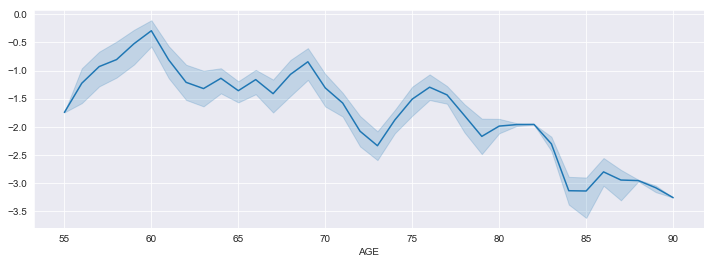

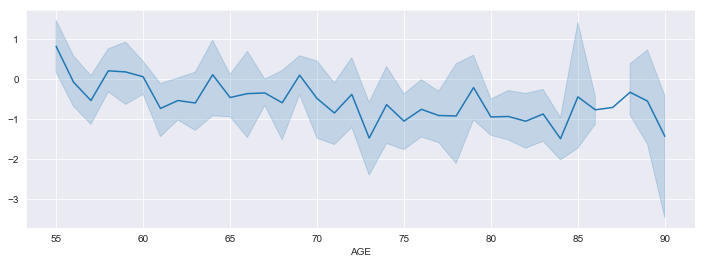

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.special import logit
from sklearn.neighbors import KernelDensity

for feature_name in ['AGE', 'HEIGHT']:
    kde = gaussian_kde([data[feature_name], 1.0 - data.FRACTURE_yes], bw_method=0.01 * data[feature_name].std())
    smoothed_labels =  kde([data[feature_name], 1.0 - data.FRACTURE_yes])
    smoothed_logits = logit(smoothed_labels)
    plt.figure(figsize=(12, 4))
    sns.lineplot(data.AGE, smoothed_logits)

Попробуем исключить влиятельные наблюдения и перестроить модель: 

In [24]:
final_formula = 'FRACTURE_yes ~ AGE + HEIGHT + PRIORFRAC_yes + MOMFRAC_yes + ARMASSIST_yes + RATERISK_less +' \
                'AGE:PRIORFRAC_yes + MOMFRAC_yes:ARMASSIST_yes'

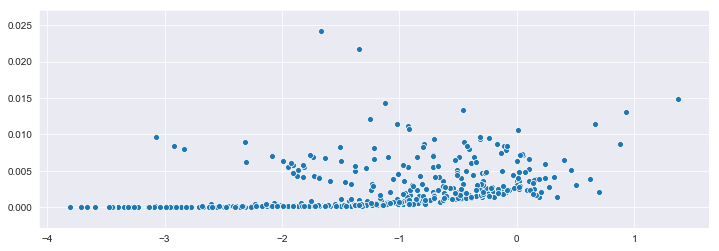

In [25]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

final_features = np.array(data[['AGE', 'HEIGHT', 'PRIORFRAC_yes', 'MOMFRAC_yes', 'ARMASSIST_yes', 'RATERISK_less']])
final_features = np.hstack((final_features, 
                            np.reshape(data['AGE'].values * data['PRIORFRAC_yes'].values, (-1, 1)), 
                            np.reshape(data['MOMFRAC_yes'].values * data['ARMASSIST_yes'].values, (-1, 1)),
                           )).astype('float')
cooks_model = GLM(data['FRACTURE_yes'], final_features, family=families.Binomial()).fit()

infl = cooks_model.get_influence()
plt.figure(figsize=(12, 4))
sns.scatterplot(model2.fittedvalues, infl.cooks_distance[0])

Попробуем фильтрацию по порогу 0.015

In [26]:
new_data = data[infl.cooks_distance[0] < 0.015]
print('Fitting on {} / {} of samples'.format(len(new_data), len(data)))
model_cooks = smf.logit(final_formula, data=new_data).fit()
print(model_cooks.summary())

Fitting on 498 / 500 of samples
Optimization terminated successfully.
         Current function value: 0.493430
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           FRACTURE_yes   No. Observations:                  498
Model:                          Logit   Df Residuals:                      489
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                  0.1173
Time:                        16:57:24   Log-Likelihood:                -245.73
converged:                       True   LL-Null:                       -278.38
Covariance Type:            nonrobust   LLR p-value:                 4.193e-11
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.9893      3.40

In [27]:
pd.concat((model_cooks.params, model3.params, 
           (model_cooks.params - model3.params) / model3.params), axis=1)

,0,1,2
Intercept,1.989286,1.477411,0.346468
AGE,0.059353,0.057560,0.031145
HEIGHT,-0.047351,-0.043386,0.091386
PRIORFRAC_yes,4.644988,4.693927,-0.010426
MOMFRAC_yes,1.230739,1.214632,0.013261
ARMASSIST_yes,0.626931,0.632049,-0.008097
RATERISK_less,-0.594234,-0.551568,0.077353
AGE:PRIORFRAC_yes,-0.055022,-0.056109,-0.019364
MOMFRAC_yes:ARMASSIST_yes,-1.648842,-1.251162,0.317848


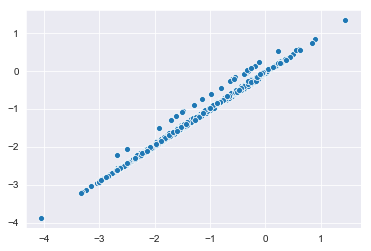

In [28]:
sns.scatterplot(model_cooks.fittedvalues, model3.fittedvalues)

In [29]:
model_cooks.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           FRACTURE_yes   No. Observations:                  498
Model:                          Logit   Df Residuals:                      489
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                  0.1173
Time:                        16:57:24   Log-Likelihood:                -245.73
converged:                       True   LL-Null:                       -278.38
Covariance Type:            nonrobust   LLR p-value:                 4.193e-11
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.9893      3.407      0.584      0.559      -4.689       8.667
AGE                           0.0594      0.017      3.518      0.000       0.026       0.092
HEIGHT                       -0.0474      0.019     -2.523      0.012      -0.084      -0.011
PRIORFRAC_yes                 4.6450      1.890      2.458      0.014       0.941       8.349
MOMFRAC_yes                   1.2307      0.397      3.102      0.002       0.453       2.008
ARMASSIST_yes                 0.6269      0.254      2.470      0.014       0.129       1.124
RATERISK_less                -0.5942      0.260     -2.285      0.022      -1.104      -0.085
AGE:PRIORFRAC_yes            -0.0550      0.026     -2.108      0.035      -0.106      -0.004
MOMFRAC_yes:ARMASSIST_yes    -1.6488      0.653     -2.527      0.012      -2.928      -0.370
=============================================================================================
"""

In [30]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           FRACTURE_yes   No. Observations:                  500
Model:                          Logit   Df Residuals:                      491
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                  0.1119
Time:                        16:57:24   Log-Likelihood:                -249.71
converged:                       True   LL-Null:                       -281.17
Covariance Type:            nonrobust   LLR p-value:                 1.245e-10
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.4774      3.362      0.439      0.660      -5.113       8.067
AGE                           0.0576      0.017      3.461      0.001       0.025       0.090
HEIGHT                       -0.0434      0.019     -2.344      0.019      -0.080      -0.007
PRIORFRAC_yes                 4.6939      1.878      2.500      0.012       1.013       8.374
MOMFRAC_yes                   1.2146      0.394      3.082      0.002       0.442       1.987
ARMASSIST_yes                 0.6320      0.252      2.504      0.012       0.137       1.127
RATERISK_less                -0.5516      0.256     -2.151      0.032      -1.054      -0.049
AGE:PRIORFRAC_yes            -0.0561      0.026     -2.164      0.030      -0.107      -0.005
MOMFRAC_yes:ARMASSIST_yes    -1.2512      0.622     -2.013      0.044      -2.469      -0.033
=============================================================================================
"""

Модель поменялась значительно, удалим два наблюдения из выборки.

In [31]:
final_model = model_cooks

## Качество классификации

Text(0.5, 0, 'Cutoffs')

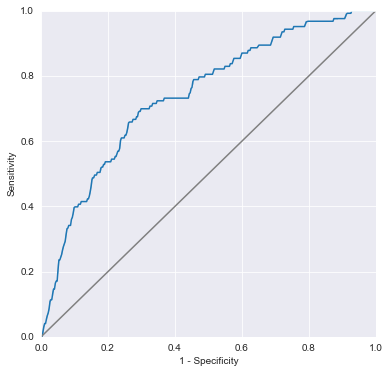

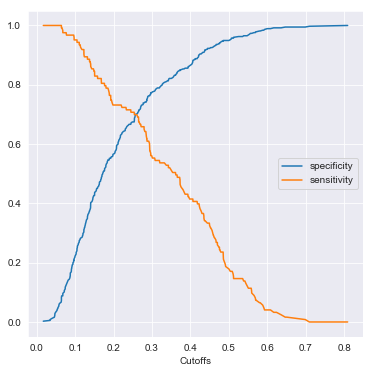

In [32]:
scores = 1.0 / (1.0 + np.exp(-final_model.fittedvalues))
sorted_scores = np.sort(scores)

labels = new_data['FRACTURE_yes']
n1 = labels.sum()
n = len(labels)

sensitivity = np.zeros_like(scores)
specificity = np.zeros_like(scores)
for j, u in enumerate(sorted(scores)):
    sensitivity[j] = np.sum((scores >= u) * labels) / float(n1)
    specificity[j] = np.sum((scores <= u) * (1 - labels)) / float(n - n1)

plt.figure(figsize=(6, 6))
sns.lineplot(1 - specificity, sensitivity)
plt.plot([0,1], [0,1], '-', color='grey')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.figure(figsize=(6, 6))
sns.lineplot(sorted(scores), specificity, label='specificity')
sns.lineplot(sorted(scores), sensitivity, label='sensitivity')
plt.xlabel('Cutoffs')

Подберём порог визуально по последнему графику: приблизительно 0.25

In [33]:
idx = np.nonzero(sorted_scores >= 0.25)[0][0]
print('For cutoff {:.4f}: specificity={:.4f}, sensitivity={:.5f}'.format(
    scores[idx], specificity[idx], sensitivity[idx]
))

For cutoff 0.2555: specificity=0.6747, sensitivity=0.70732


При пороге 0.2555 построенная модель обеспечивает чувствительность 0.70732 и специфичность 0.0.6747

Посчитаем по итоговой модели приросты отношений шансов на единицу каждого признака и доверительные интервалы для них:

In [34]:
confint_results = np.exp(pd.concat((final_model.params, final_model.conf_int()), axis=1))
confint_results.columns = ['coef', 'confint_2.5', 'confint_97.5']
confint_results

,coef,confint_2.5,confint_97.5
Intercept,7.310312,0.009198,5810.215282
AGE,1.061149,1.026630,1.096830
HEIGHT,0.953752,0.919307,0.989488
PRIORFRAC_yes,104.062114,2.561343,4227.829527
MOMFRAC_yes,3.423760,1.573239,7.450953
ARMASSIST_yes,1.871857,1.138112,3.078652
RATERISK_less,0.551985,0.331561,0.918951
AGE:PRIORFRAC_yes,0.946464,0.899271,0.996134
MOMFRAC_yes:ARMASSIST_yes,0.192272,0.053507,0.690908


## Выводы
* каждый год относительный риск перелома шейки бедра у женщин, с которыми он ещё не происходил, возрастает на 6% (2.6%, 9.68%); при этом для женщин, у которых уже был перелом, увеличение возраста не приносит дополнительного значимого увеличения риска перелома
* для женщин, с которыми уже случался перелом шейки бедра, риск нового перелома в течение года существенно выше (в 104 раза, 95% доверительный интервал (2.56, 4427);
* при прочих равных для женщин маленького роста риск перелома выше — на каждые 10 сантиметров уменьшения роста приходится увеличение риска перелома на 60% (11%, 31%);
* для женщин, у матерей которых не было перелома шейки бедра, неспособность самостоятельно вставать из сидячего положения связана с повышением риска перелома в 1.87 раз (1.13, 3.07);
* для женщин, которые способны самостоятельно вставать из сидячего положения, наличие перелома у матери связано с повышением риска перелома в 3.42 раз (1.57, 7.45);
* женщины, оценивающие вероятность своего перелома как низкую, действительно при прочих равных имеют шанс перелома ниже в 1.81 раз (1.08, 3.01).